In [25]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# torch.rand(): 0~1 사이의 실수에서 난수를 생성해서 텐서를 만듦 
# torch.rand_like(input): 인풋과 같은 형태(shape)로 0~1 사이의 실수에서 난수를 생성해서 텐서를 만듦

In [26]:
torch.manual_seed(975)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
batch_size = 64
epochs = 50
log_interval = 100
learning_rate = 1e-3
latent_dim = 20
num_classes = 10
input_dim = 784

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
    ])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=batch_size, shuffle=True)

In [29]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        # 인코더
        self.fc1 = nn.Linear(input_dim + num_classes, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)
        # 디코더
        self.fc3 = nn.Linear(latent_dim + num_classes, 512)
        self.fc4 = nn.Linear(512, input_dim)

    def encode(self, x, labels):
        combined = torch.cat([x, labels], dim=1)
        h1 = F.relu(self.fc1(combined))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        combined = torch.cat([z, labels], dim=1)
        h3 = F.relu(self.fc3(combined))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, labels):
        mu, logvar = self.encode(x.view(-1, 784), labels)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels), mu, logvar


In [30]:
def loss_function(recon_x, x, mu, logvar):
    # x를 평탄화하여 recon_x와 동일한 차원으로 만듦
    x_flat = x.view(-1, 784)
    BCE = F.binary_cross_entropy(recon_x, x_flat, reduction='sum')
    
    # KL 발산
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [31]:
model = CVAE()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [32]:
class_latent_stats = defaultdict(lambda: {'mu': [], 'logvar': []})

def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        labels = torch.zeros(target.size(0), num_classes).to(device).scatter_(1, target.unsqueeze(1), 1)
        recon_batch, mu, logvar = model(data, labels)

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # 클래스별 잠재 변수 평균과 분산 수집
        for i in range(len(target)):
            label = target[i].item()
            class_latent_stats[label]['mu'].append(mu[i].detach().cpu().numpy())
            class_latent_stats[label]['logvar'].append(logvar[i].detach().cpu().numpy())
    
    average_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average loss: {average_loss:.4f}')


In [33]:
def visualize_class_samples(model, class_label, num_samples):
    model.eval()
    with torch.no_grad():
        # 클래스별 평균과 분산 계산
        class_mu = np.mean(class_latent_stats[class_label]['mu'], axis=0)
        class_logvar = np.mean(class_latent_stats[class_label]['logvar'], axis=0)
        class_std = np.exp(0.5 * class_logvar)

        # 클래스별 정규 분포에서 샘플링
        z = torch.randn(num_samples, latent_dim).to(device)
        z = z * torch.from_numpy(class_std).float().to(device) + torch.from_numpy(class_mu).float().to(device)

        # 디코더를 통해 이미지 생성
        recon_images = model.decode(z, torch.eye(num_classes)[class_label].to(device).repeat(num_samples, 1)).cpu()

        # 시각화
        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            plt.subplot(5, 5, i + 1)
            plt.imshow(recon_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

In [34]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)

Epoch 1, Average loss: 141.6104
Epoch 2, Average loss: 112.1194
Epoch 3, Average loss: 107.6211
Epoch 4, Average loss: 105.3244
Epoch 5, Average loss: 103.9853
Epoch 6, Average loss: 103.0080
Epoch 7, Average loss: 102.2530
Epoch 8, Average loss: 101.6943
Epoch 9, Average loss: 101.2175
Epoch 10, Average loss: 100.8115
Epoch 11, Average loss: 100.3863
Epoch 12, Average loss: 100.0986
Epoch 13, Average loss: 99.8364
Epoch 14, Average loss: 99.5567
Epoch 15, Average loss: 99.3363
Epoch 16, Average loss: 99.1210
Epoch 17, Average loss: 98.9575
Epoch 18, Average loss: 98.7765
Epoch 19, Average loss: 98.5462
Epoch 20, Average loss: 98.4388
Epoch 21, Average loss: 98.2689
Epoch 22, Average loss: 98.1411
Epoch 23, Average loss: 97.9817
Epoch 24, Average loss: 97.9110
Epoch 25, Average loss: 97.7621
Epoch 26, Average loss: 97.6870
Epoch 27, Average loss: 97.5391
Epoch 28, Average loss: 97.4607
Epoch 29, Average loss: 97.3558
Epoch 30, Average loss: 97.2841
Epoch 31, Average loss: 97.1943
Epoch

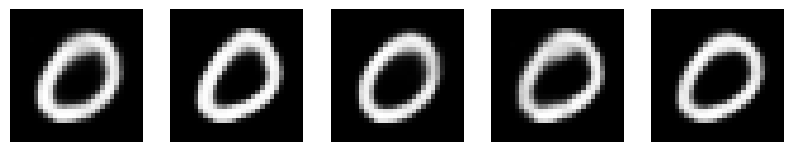

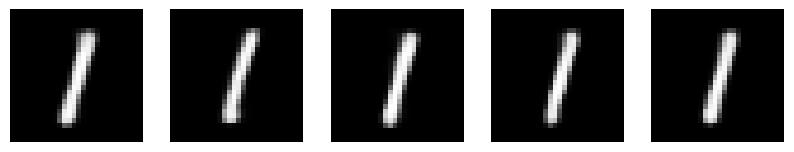

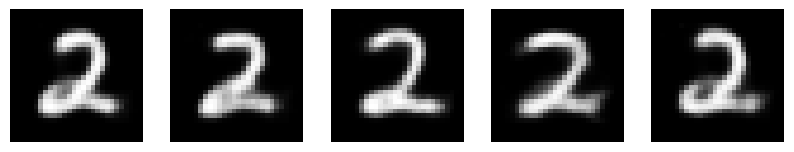

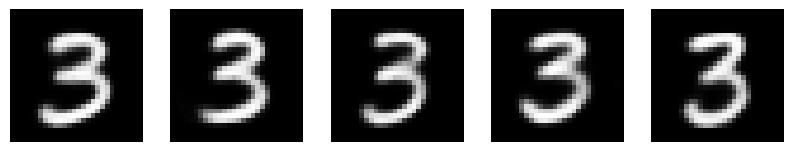

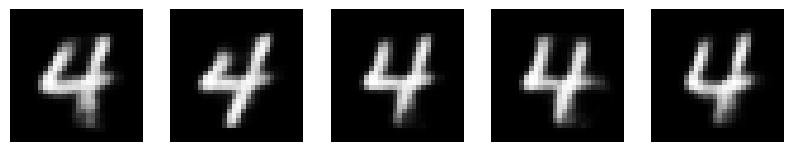

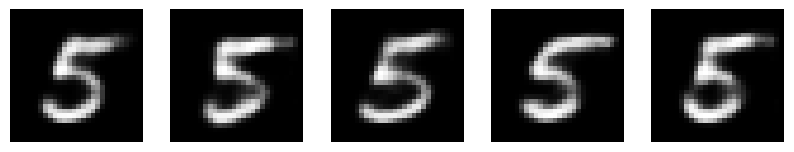

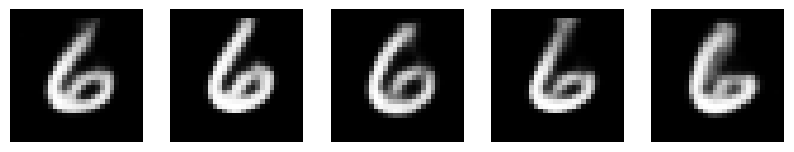

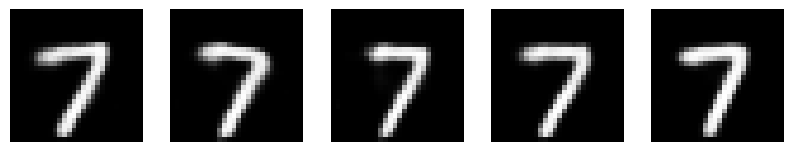

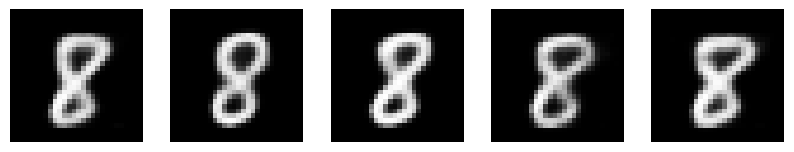

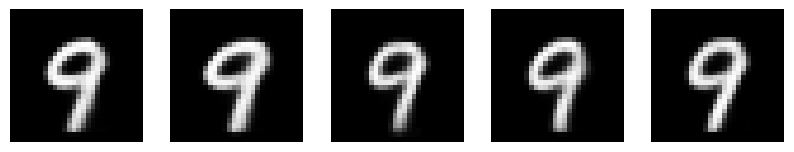

In [35]:
for i in range(10):
    visualize_class_samples(model, class_label=i, num_samples=5)